# Passing spatial data through a KDTree in Spark
## Or: the best coffee shop in Hong Kong for Pokemon
In my day job, I often work with spatial data. Inevitably when working with spatial data, you want to find the closest places to a given location. For example, you might want to find the closest restaurant to where you are. One of the most efficient ways to do this is with a KDTree, a type of binary search tree for space.

My favourite analysis tool is Spark, but it took me a little while to figure out how to work with spatial data in Spark. Google doesn't yield any tutorials on using KDTrees in PySpark, so this is a short tutorial on how to do it. I thought it would be fun to use KDTrees to find out which coffee shops in Hong Kong have the most Pokemon nearby.

Some shortcuts:

[Exploring the Pokemon data](#pokemon)

[Exploring the coffee shop data](#coffee)

[Using KDTrees in python](#kdtree)

[Using KDTrees in Spark](#spark)

[Performance of DataFrames vs RDDs](#rdd)



Before we get to the fun stuff, we need to import some libraries.

In [29]:
import pandas as pd
import numpy as np
import json
import glob
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

<a id='pokemon'></a>

## Load pokemon sightings
It was surprisingly hard to get pokemon data. I tried scraping the data myself, but Niantic (the developers of Pokemon Go) actively discourages that. In the end, I found the easiest place to get data was a Hong Kong Pokemon tracker, https://pokemon.appx.hk/. I visited that website ten times, and viewed the source code to get JSON objects with Pokemon locations (to get the locations, hit F12 to access the Source mode, then go to the Network tab, then the XHR sub-tab, and select the top element. If the `top` object is not there, try reloading the page with source view open).

After I downloaded the Pokemon location JSONs, I made the helper function below to load them using pandas, then created a single dataframe with all the data.

In [2]:
def load_poke_json( pokefile):
    return pd.read_json( pokefile ).rename(columns={'a':'lat', 'i':'type',
                                                    't':'ts','o':'lon'})

In [3]:
hk_poke_json = glob.glob('data/hk-*.json')
hk_poke_df = pd.concat(map(load_poke_json, hk_poke_json))
hk_poke_df[['type', 'lat', 'lon', 'ts']].describe()

,type,lat,lon,ts
count,18732.000000,18732.000000,18732.000000,1.873200e+04
mean,72.515962,22.360742,114.120928,1.483272e+09
std,44.163666,0.079498,0.096489,2.276936e+06
min,2.000000,22.168887,113.843555,1.481390e+09
25%,35.000000,22.294679,114.039440,1.481743e+09
50%,66.000000,22.362630,114.136643,1.482812e+09
75%,96.000000,22.427240,114.194142,1.483212e+09
max,246.000000,22.553828,114.378200,1.489282e+09


The data from appx.hk has four main columns of interest: pokemon type, lat, lon, and timestamp. (There are also columns labeled `ia`, `id`, and `is`, but I don't know what they are). There are over 18,000 pokemon sightings. We can use `value_counts` to find out which pokemon are most common.

In [4]:
hk_poke_df.type.value_counts().head()

35     2823
79     1361
102     866
27      766
42      758
Name: type, dtype: int64

Two types of Pokemon are over 20% of the Pokemon! To see the distribution of all Pokemon, we can plot the counts:

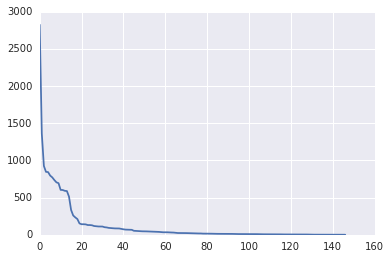

In [16]:
plt.plot(hk_poke_df.type.value_counts().values );

The top 20 Pokemon account for a vast majority! The 50 most common Pokemon were spotted < 10 times over the ten observations.

As a last bit of exploratory fun, we can plot the locations of 5000 of the Pokemon.

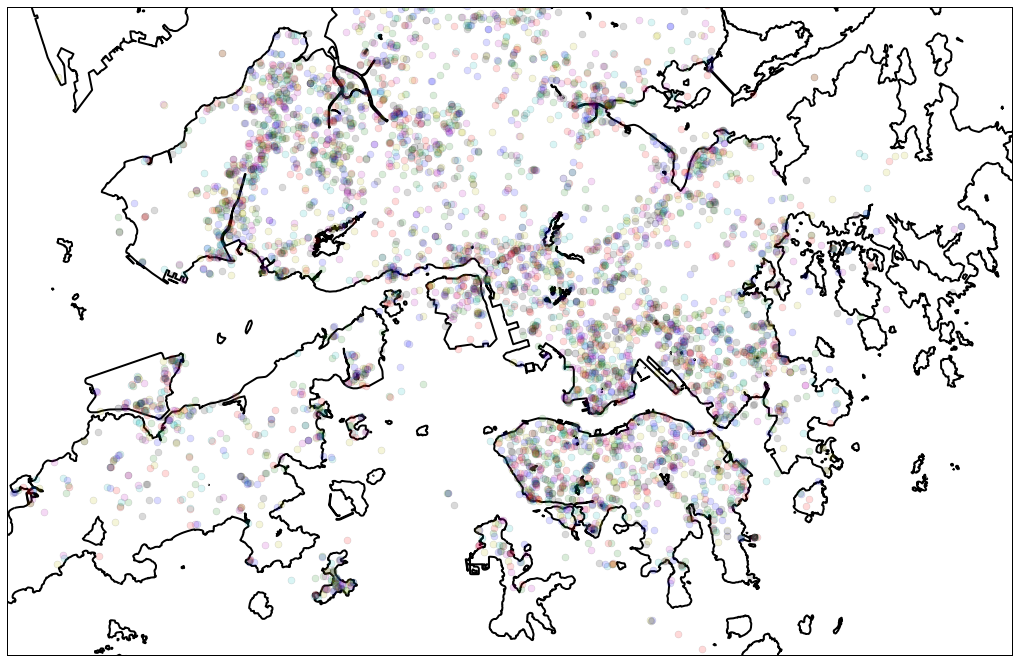

In [4]:
from mpl_toolkits.basemap import Basemap
lw = 2

fig, ax = plt.subplots(1,figsize = (18,12))
map = Basemap(llcrnrlon=113.85,llcrnrlat=22.17,urcrnrlon=114.4,urcrnrlat=22.5,
             resolution='i', projection='tmerc', lat_0 = 22.3, lon_0 = 114.1)

map.readshapefile('shapefiles/hong_kong_water', 'hongkong', linewidth=2)
map.readshapefile('shapefiles/hong_kong_coastline', 'coast', linewidth=2)
for index, pokemon in hk_poke_df.head(5000).iterrows():
    map.plot(pokemon['lon'],pokemon['lat'] , latlon=True, marker = 'o'
             markersize = 7, alpha = 0.15)
plt.show()

The Pokemon are distributed all over the greater Hong Kong area, and are concentrated in high population locations like Hong Kong, Kowloon, and the airport.

Now that we have a single dataset, we can save it as a csv to load into PySpark. (You can actually load the data directly using `spark.create.DataFrame()`, but wanted to save the intermediate dataset so people don't have to remake it.)

In [6]:
hk_poke_df[['lat', 'lon', 'ts', 'type']].to_csv( 'hk_pokemon.csv', index = False,
                                                header = False)

<a id='coffee'></a>
## Load Hong Kong coffee locations
To get coffee shop locations, I queried the [FourSquare API](https://developer.foursquare.com/), using this [python package](https://pypi.python.org/pypi/foursquare/). As a free plug, I've found the FourSquare API has the most user friendly API of any review website. I adapted a [scraper function from another project](https://github.com/map222/Kibbeh/blob/master/src/API_io.py#L75) to get a list of Hong Kong coffee shops by lat / long.

I used the scraper to create a list of 586 coffee shops, and saved it into `hk_cofee.json`. (There are probably a lot more coffee shops, but refining the coffee shop scraper is beyond the scope of this notebook).

In [5]:
hk_coffee_df = pd.io.json.json_normalize( json.loads(open('hk_coffee.json').read() ) )[['location.lat', 'location.lng', 'name']]
hk_coffee_df.shape

(586, 3)

In [7]:
# Around a quarter of the coffee shops were Starbucks
hk_coffee_df.name.str.startswith('Starbucks').sum()

150

We can plot the locations of the coffee shops to make sure we have good coverage of the island.

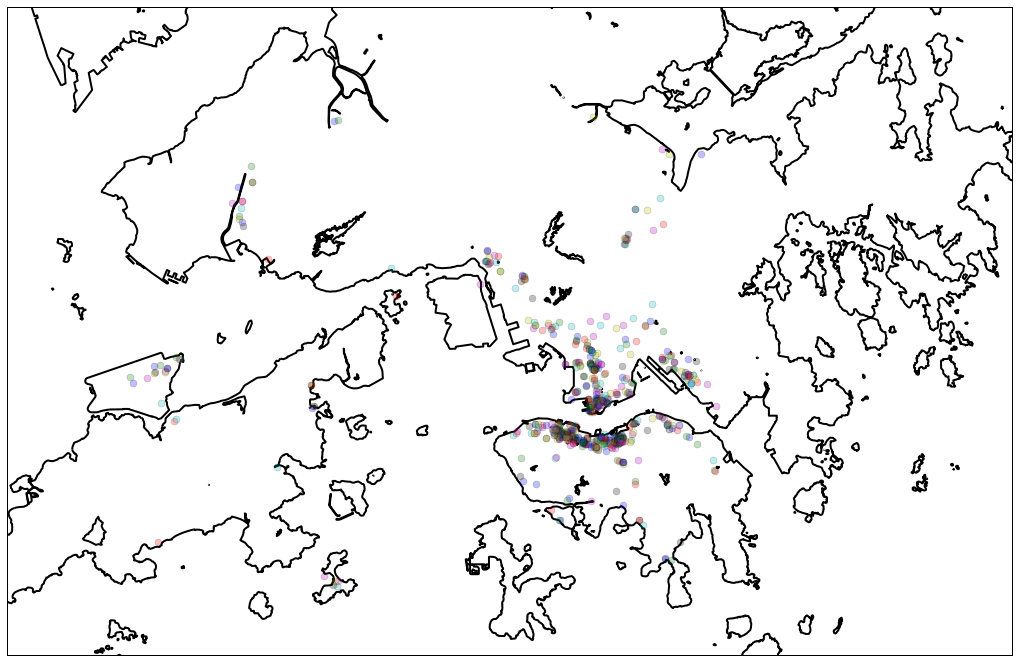

In [6]:
fig, ax = plt.subplots(1,figsize = (18,12))
map = Basemap(llcrnrlon=113.85,llcrnrlat=22.17,urcrnrlon=114.4,urcrnrlat=22.5,
             resolution='i', projection='tmerc', lat_0 = 22.3, lon_0 = 114.1)

map.readshapefile('shapefiles/hong_kong_water', 'hongkong', linewidth =lw)
map.readshapefile('shapefiles/hong_kong_coastline', 'coast', linewidth =lw)
for index, coffee_shop in hk_coffee_df.iterrows():
    map.plot(coffee_shop['location.lng'],coffee_shop['location.lat'],
             latlon=True, marker = 'o', markersize = 7, alpha = 0.25)
plt.show()

Most of the coffee shops from Foursquare are in the population centers of Hong Kong and Kowloon. This may reflect a limitation of the Foursquare data covering Chinese language areas. In any case, most people probably want to visit coffee shops in those areas anyway!


<a id='kdtree'></a>
## Tutorial on KDTrees

As mentioned at the start, KDTrees are an efficient way to calculate nearest neighbors with spatial data. In this Pokemon example, if wanted to calculate the nearest coffee shop to each Pokemon using a brute force approach, we would have to calculate the distance between each Pokemon and each coffee shop, which would have time complexity:

$P_{pokemon} * C_{coffee shops} \approx O(n^2)$

KDtrees allow you to replace one of those complexity terms with a log, as KDTrees are a form of search tree. This reduces the time complexity to:

$P_{pokemon} * log(C_{coffee shops}) \approx O(n\ log(n))$

To explore how KDTrees can find Pokemon, we can use the package scipy, which has an implementation of KDTrees. I chose to build a KDTree of the coffee shop locations rather than the Pokemon locations since there are fewer coffee shops, and it will be faster to build the KDTree. Scipy has two types of KDTree in the library, compiled in python or C. I strongly recommend using the C version (cKDTree), as it is orders of magnitude quicker. Building the KDTree is as simple as calling the constructor:

In [8]:
coffee_kdtree = cKDTree(hk_coffee_df[['location.lat', 'location.lng']] )

To query the KDTree, we are going to pass the Pokemon locations into the tree to find the nearest coffee shops to each Pokemon. To do that we need two parameters. First, we need the radius around each Pokemon that we are interested in. Here I chose 50m, since that is around the radius of the Pokemon tracker. Second we need to limit the number of coffee shops to return. I arbitrarily chose 5. I am also timing this query to compare to the brute force approach.

In [14]:
%%timeit
radius = 0.0005 # the pokemon should be within ~50 meters of a coffee shop

kdtree_counts = coffee_kdtree.query( hk_poke_df[['lat', 'lon']],
                                    
                                    k=5, # return a maximum of 10  shops
                                    
                                    distance_upper_bound=radius )

100 loops, best of 3: 14.2 ms per loop


The result of the KDtree query is tuple: the first element is the distances to nearby coffee shops (where `inf` means no coffee shops are nearby. The second element is the index of the nearby coffee shops. The display below shows that the first and last pokemon didn't have any coffee shops nearby.

In [17]:
kdtree_counts

(array([[ inf,  inf,  inf,  inf,  inf],
        [ inf,  inf,  inf,  inf,  inf],
        [ inf,  inf,  inf,  inf,  inf],
        ..., 
        [ inf,  inf,  inf,  inf,  inf],
        [ inf,  inf,  inf,  inf,  inf],
        [ inf,  inf,  inf,  inf,  inf]]), array([[586, 586, 586, 586, 586],
        [586, 586, 586, 586, 586],
        [586, 586, 586, 586, 586],
        ..., 
        [586, 586, 586, 586, 586],
        [586, 586, 586, 586, 586],
        [586, 586, 586, 586, 586]]))

We can join this data to the coffee shop pandas dataframe to find the coffee shops with the most Pokemon nearby

In [23]:
hk_coffee_df['kdtree_pokemon'] = pd.Series( kdtree_counts[1].ravel() ).value_counts()
hk_coffee_df = hk_coffee_df.fillna(0)
hk_coffee_df.sort_values('kdtree_pokemon', ascending=False).head(3)

,location.lat,location.lng,name,kdtree_pokemon
333,22.318484,114.174676,Starbucks,7.0
64,22.270550,114.130811,Pacific Coffee (太平洋咖啡),6.0
40,22.207968,114.029331,Coffee Seeds 阿翁,6.0


For comparison sake we can do an equivalent calculation using a brute force method. Here I am just calculating the distance between each Pokemon and each coffee shop. Notice that this take 10 times longer.

In [21]:
from sklearn.metrics.pairwise import euclidean_distances

In [22]:
%%timeit
distances = euclidean_distances(hk_coffee_df[['location.lat', 'location.lng']],
                                hk_poke_df[['lat', 'lon']])

10 loops, best of 3: 182 ms per loop


We can also verify that the brute force approach calculated the same number of Pokemon:

In [26]:
hk_coffee_df['brute_pokemon'] = [np.sum(x < 0.0005) for x in distances]
hk_coffee_df.query('brute_pokemon > 5')

,location.lat,location.lng,name,kdtree_pokemon,brute_pokemon
40,22.207968,114.029331,Coffee Seeds 阿翁,6.0,6
64,22.270550,114.130811,Pacific Coffee (太平洋咖啡),6.0,6
333,22.318484,114.174676,Starbucks,7.0,7


Finally, we can plot the locations of the best place to catch Pokemon:

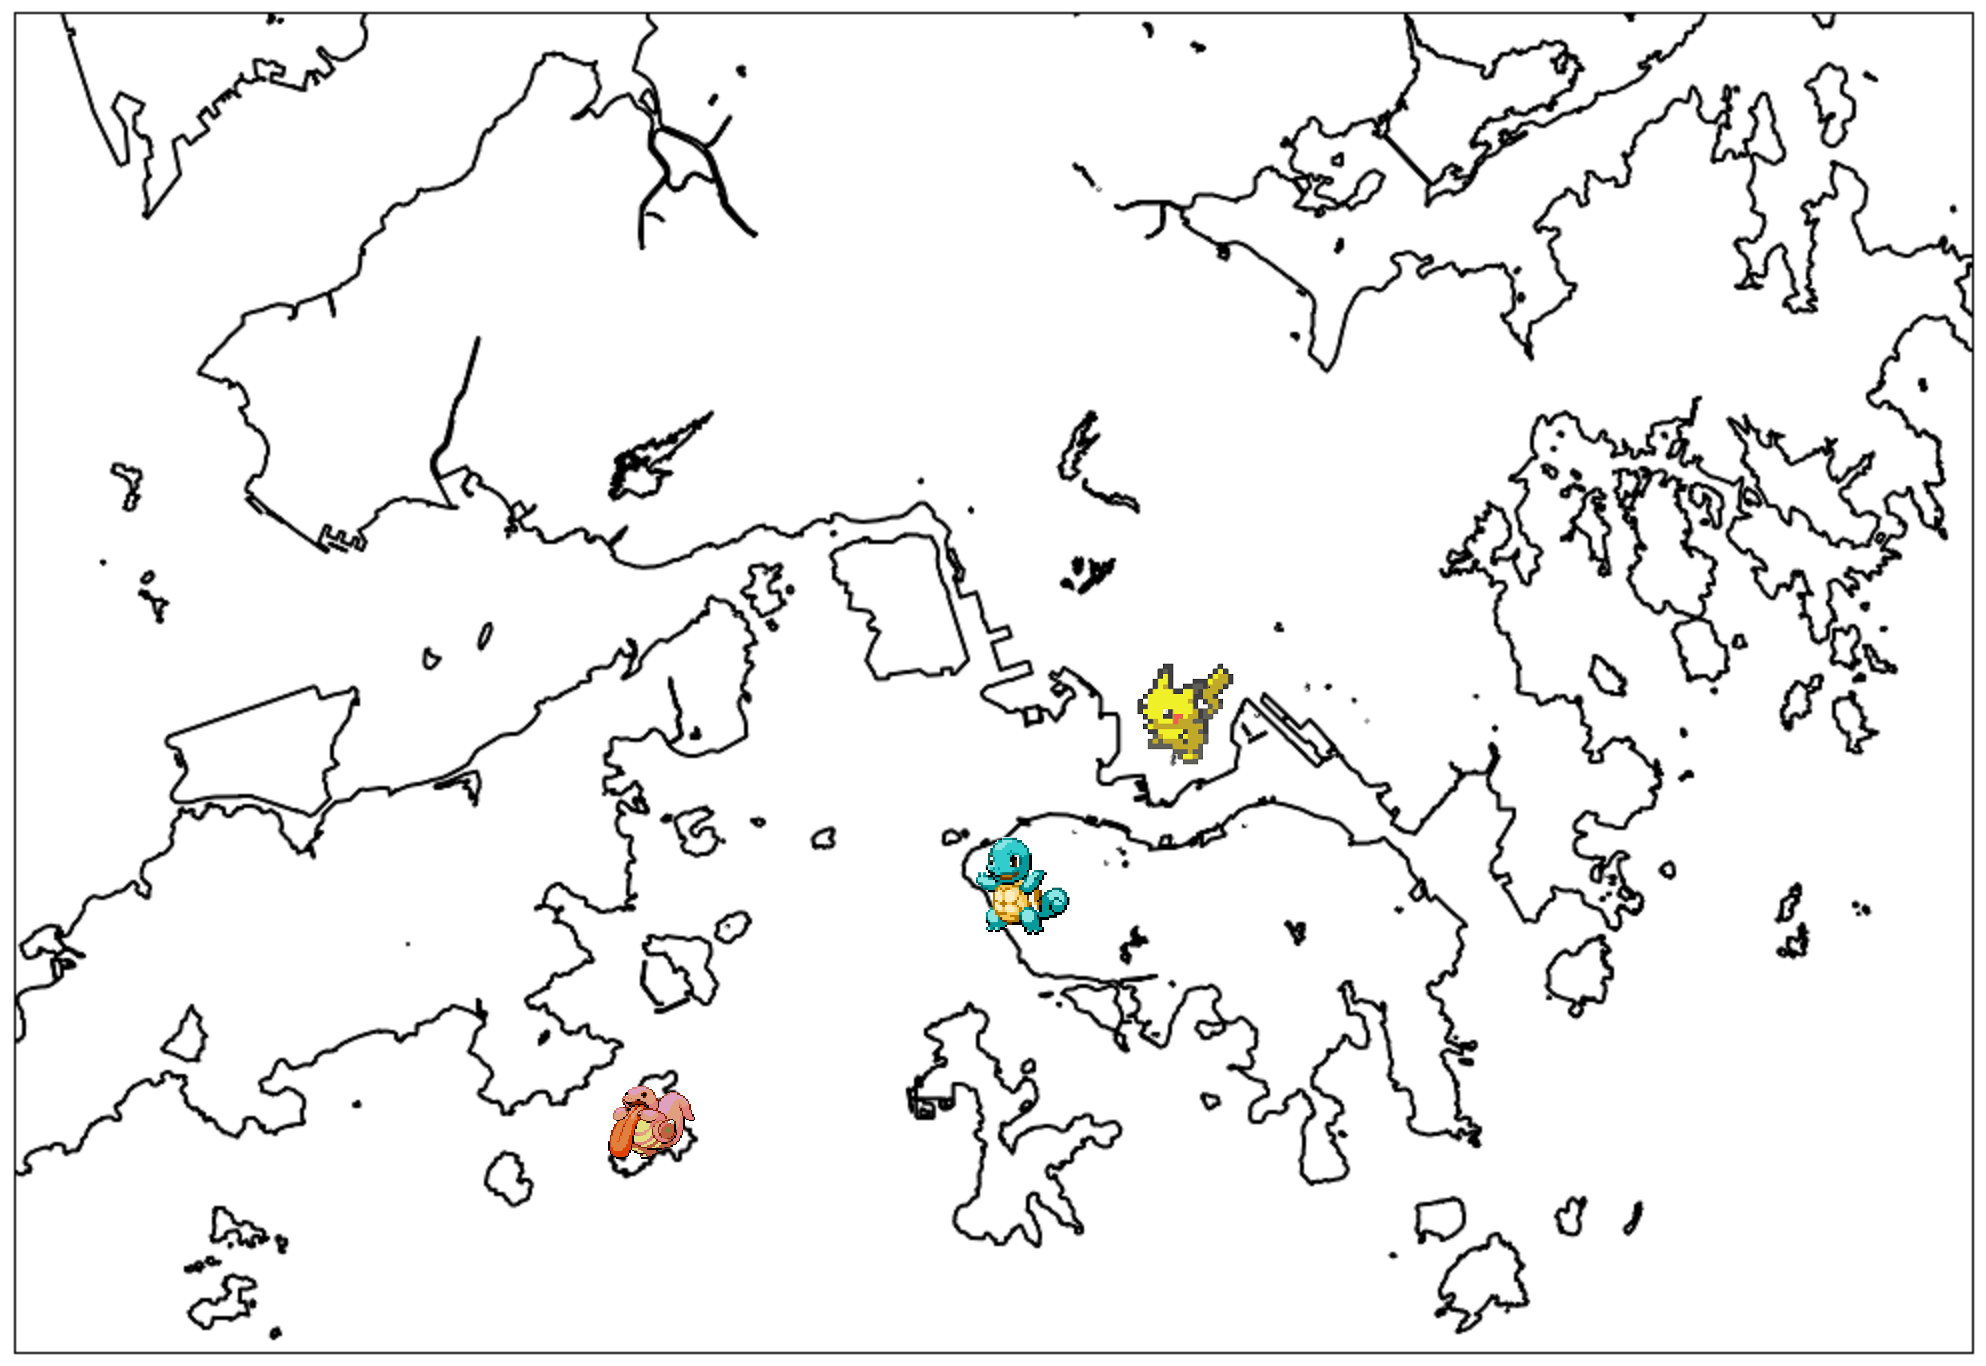

In [30]:
Image(filename= 'graphics/final map.png', width=1200) 

Two of the best places are in Kowloon and Hong Kong. My favourite place, though is on the small island of Cheung Chau. I like to imagine getting an iced coffee, sitting on the beach, and catching Lickitongues on a relaxing afternoon.

<a id='spark'></a>
# Querying KDTrees in Spark
Now that we know how KDTrees work, we can try using them in Spark! First, we can start by broadcasting the coffee_kdtree to all of the executors.

In [1]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
coffee_tree_broadcast = sc.broadcast( coffee_kdtree )

ImportError: No module named 'pyspark'

Next, we need to load the pokemon data into Spark. Here I define a simple schema using StructType, then load the pokemon csv using `spark.read.csv`, and finally `persist` the dataframe.

In [10]:
poke_schema = T.StructType([
                T.StructField('lat', T.FloatType(), False),
                T.StructField('lon', T.FloatType(), False),
                T.StructField('ts', T.FloatType(), False),
                T.StructField('type', T.IntegerType(), False)
                ])
poke_df = spark.read.csv('hk_pokemon.csv', schema = poke_schema).persist()

Finally, we need to make a function to query the KDTree. The function takes two columns from the DataFrame, and passes them through the KDTree one at a time.

In [11]:
def query_kdtree( lat, lon, cur_tree, radius = 0.0005):
    ''' query the kdtree to find locations within a radius of the lat / lon
        lat / lon: native python floats representing location
        cur_tree: a broadcast scipy cKDTree
        radius: radius, in degrees, around the pokemon to accept pokestops (default to ~50m)
    '''
    
    # a standard scipy cKDTree query, we want up to 10 coffeehouses within the radius of each pokemon
    query_results = cur_tree.value.query([lat, lon], 10, distance_upper_bound=radius)
    
    # query_results is a list of two arrays (radius, and index); we want to return the index
    # the index is a numpy integer which we needs to be cast as a python integer to return to Spark
    return [int(row[1]) for row in zip(*query_results) if row[0] < radius]

Since we are working in PySpark, we need to wrap the above function in a udf wrapper (user-defined function). The udf will be passed two columns, but we also need to set the KDTree as an argument. Here I use the `partial` function to pass `coffee_tree_broadcast`. You should also be able to use a `lambda` function to similar effect. Udf's require you to specify the return type. In this case, we are returning a list of integers, which are indices in the KDTree.

In [13]:
from functools import partial
coffee_udf = F.udf( partial(query_kdtree, cur_tree = coffee_tree_broadcast),
                    T.ArrayType( T.IntegerType() ) )

We're ready to pass the pokemon through the KDTree! To do so, we just need to add a column to the DataFrame using `withColumn`, applying the `coffee_udf`. Note that we can pass the lat and lon columns simply by naming them. After creating the new column, I use an `explode` statement to separate each shop into its own row. This should make the dataset tidier\*, as each row will represent one pokemon-shop combination.  Notice that after the explosion, the bottom two rows represent a single pokemon, and the two coffee shops it was near.

\*I think that's what tidy means.

In [13]:
nearby_df = (poke_df.withColumn('nearby_shops', coffee_udf('lat', 'lon'))
                    .select('*', F.explode('nearby_shops').alias('shop_index') ).persist() )
nearby_df.show(6)

+---------+---------+------------+----+------------+----------+
|      lat|      lon|          ts|type|nearby_shops|shop_index|
+---------+---------+------------+----+------------+----------+
|22.308178|113.91828|1.48331162E9|  27|         [0]|         0|
|22.207895|114.02905|1.48331187E9|  17|        [40]|        40|
|22.320929|113.94459|1.48331226E9|  56|        [17]|        17|
|22.205046|114.02998|1.48331162E9|  74|        [38]|        38|
|22.338083|114.13906|1.48331149E9|  35|    [92, 96]|        92|
|22.338083|114.13906|1.48331149E9|  35|    [92, 96]|        96|
+---------+---------+------------+----+------------+----------+
only showing top 6 rows



With this data we can answer some simple questions. For example, how many pokemon had a coffee shop nearby?

In [14]:
nearby_df.select('lat', 'lon', 'ts', 'type').distinct().count()

285

Or we can ask how many shops had at least one Pokemon nearby.

In [15]:
(nearby_df.select('shop_index').distinct().count() )

240

Finally, we can answer the question, which are the best coffee shops to catch pokemon? To do that, we can groupby store_index, and then aggregate by count. For display, we want to sort using `orderBy`.

In [16]:
(nearby_df.groupby('shop_index')
          .agg(F.count('shop_index').alias('num_pokemon'))
          .orderBy('num_pokemon', ascending = False).show(5) )

+----------+-----------+
|shop_index|num_pokemon|
+----------+-----------+
|        40|          6|
|        64|          5|
|       333|          5|
|       295|          5|
|       168|          5|
+----------+-----------+
only showing top 5 rows



To see which shops these are, we can go back to the original coffeshop dataframe.

In [17]:
hk_coffee_df.loc[[40, 64, 333, 295, 168]]

,location.lat,location.lng,name
40,22.207968,114.029331,Coffee Seeds 阿翁
64,22.270550,114.130811,Pacific Coffee (太平洋咖啡)
333,22.318484,114.174676,Starbucks
295,22.296741,114.169362,Starbucks
168,22.283222,114.159201,Starbucks


It turns out the best place is a [local place on a tiny southern island](https://foursquare.com/v/coffee-seeds-%E9%98%BF%E7%BF%81/4f547dbfe4b0bf6b5f624b57/)!

In [18]:
hk_coffee_df.name.str.startswith('Starbucks').sum()

150

For kicks, we can also see how many were Starbucks. 150 out of 580! This probably reflects the limitations of our original dataset, as we scraped the coffee shop locations using Four Square. If anyone has a better coffee shop list, let me know!

<a id='rdd'></a>
# Performance of DataFrames vs RDDs
If you go to any Spark workshop or meetup, you will inevitably be told that DataFrames are a lot faster and easier to work with than RDDs. While this dataset is a probably too small for a proper investigation, I thought I'd run some benchmarks to see. To start with, let's see how fast the query is using DataFrames.

In [14]:
%time (poke_df.repartition(1).withColumn('nearby_shops', coffee_udf('lat', 'lon')).count() )

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.68 s


16565

1.7 seconds for our 16,000 locations using DataFrames. For RDDs, we can write a similar function, and `map` it.

In [15]:
def query_kdtree_rdd( row, map_tree, radius = 0.0005):
    # first we need to convert the row to a dictionary
    cur_row = row.asDict()
    
    # pass the dictionary through the KDTree
    query_results = map_tree.value.query([row['lat'], row['lon']], 10, distance_upper_bound=radius)
    
    # then convert the results back into a dictionary / row
    cur_row['indices'] =  [int(row[1]) for row in zip(*query_results) if row[0] < radius]
    return Row(**cur_row)

In [16]:
%time poke_df.rdd.map(partial(query_kdtree_rdd, map_tree = coffee_tree_broadcast)).count()

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 1.62 s


16565

Only a little bit slower! What if we use `mapPartitions`, which processes an entire partition in one go?

In [17]:
# naive mapPartitions
def query_kdtree_mappartitions(iterator):
    radius = 0.0005
    new_rows = []
    for row in iterator:
        cur_row = row.asDict()
        query_results = coffee_tree_broadcast.value.query([cur_row['lat'], cur_row['lon']], 10, radius)
        cur_row['indices'] =  [int(row[1]) for row in zip(*query_results) if row[0] < radius]
        new_rows.append(Row(**cur_row))
    return new_rows

In [18]:
%time poke_df.rdd.mapPartitions(query_kdtree_mappartitions).count()

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.09 s


16565

30% faster! In previous KDTree benchmarks I've tried, the DataFrame method is ~2x faster than the mapPartitions method. My guess is that this dataset is small enough that the advantages of DataFrames can't shine through. 


## Conclusion
Anyway, this is one way to use KDTrees in PySpark! Some of the key general concepts for me were:
1. Learning how to define `UDF`s on multiple columns of data
2. Figuring out how to pass the KDTree to the function using `partial`
3. Being careful to return native python types, and using the right DataTypes
    
Good Pokehunting and tree searching!